In [1]:
import lorm
from nfft import nfft
import disc.energy_curveling_3d
from pythreejs import *
from IPython.display import display
#from ipywidgets import VBox, HBox, Checkbox, jslink
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
N_half = 50
m = 2*N_half
x = np.linspace(-0.5,0.5,m,endpoint=False)
x1,x2,x3 = np.meshgrid(x,x,x)
quat_nodes = np.array([x3.ravel()[:],x1.ravel()[:],x2.ravel()[:]]).transpose()
sample = 1.2*(np.loadtxt('data/spock.uo')-np.array([0.5,0.5,0.45]))
#mu = np.zeros([m**3],dtype=np.float)
#for s in sample:
#    mu[:] += np.exp(-30000*((quat_nodes[:,0]-s[1])**2+(quat_nodes[:,1]-s[2])**2+(quat_nodes[:,2]+s[0])**2))
#plt.imshow(mu.reshape([m,m,m])[:,:,10],vmin=0)#,vmax=1)

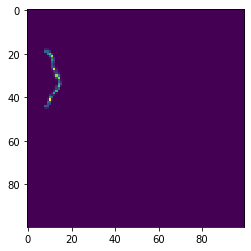

In [4]:
mu=np.loadtxt('spock_voxel.txt')
m=int(mu.shape[0]**(1./3))+1
plt.imshow(mu.reshape([m,m,m])[:,:,16],vmin=0)#,vmax=1)
#np.savetxt('spock_voxel.txt',mu)

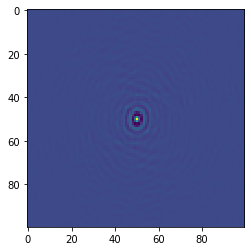

In [5]:
#mu = np.zeros([m**3],dtype=np.float)
#mu[:] = nn.exp(-10*(quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2))
#mu[:] = (quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2) < 0.45**2
#mu[:]-= (quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2) < 0.4**2
#plt.imshow(mu.reshape([m,m,m])[:,N_half,:],vmin=0,vmax=1)
nfft3d = nfft.NFFT3D(m**3,2*N_half,2*N_half,2*N_half)
nfft3d.x = quat_nodes
nfft3d.precompute_x()
nfft3d.f = mu/m**3
nfft3d.adjoint()
mu_hat = np.zeros([2*N_half,2*N_half,2*N_half],dtype=np.complex)
mu_hat[:] = nfft3d.f_hat/nfft3d.f_hat[N_half,N_half,N_half]
plt.imshow(np.real(mu_hat[:,N_half,:]))

In [6]:
def update_points(p):
    g1.attributes['position'].array = p.coords
    return

In [7]:
e3 = lorm.manif.EuclideanSpace(3)
points = lorm.manif.ManifoldPointArray(e3)
m = 200
#points.coords = 0.3*(np.random.rand(m,3)-0.5)
points.coords = np.zeros([m,3])
t = np.linspace(0,2*np.pi,m,endpoint=False)
#points.coords[:,0] = 0.3*np.sin(t)
#points.coords[:,1] = 0.3*np.cos(t)
#points.coords[:,2] = 0.3*np.sin(t)
#points.coords = 0.4*np.loadtxt('s2_4design.txt')
points.coords = np.loadtxt('spock_lines.txt')

In [8]:
N=2*N_half
m = points.coords.shape[0]
energy = disc.energy_curveling_3d.plan(m,N,0.0000001,5)
energy._mu_hat[:] = mu_hat
m

25600

In [9]:
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords, normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =800
renderer.height =800
display(renderer)

/home/grman/.local/lib/python3.7/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [26]:
#method = lorm.optim.SteepestDescentMethod(max_iter=100)
method = lorm.optim.ConjugateGradientMethod(max_iter=1)
method.listener = update_points
#points_new = lorm.manif.ManifoldPointArray(e3)
#points_new.coords = points.coords
for i in range(3):
    points_new = method.run(energy,points_new)

Initial value: f[0] = 1.6781148935853302e-05
f[1] = 1.6780876833307657e-05
Reached maximal iterations!
Initial value: f[0] = 1.6780876833307657e-05
f[1] = 1.6780700422141587e-05
Reached maximal iterations!
Initial value: f[0] = 1.6780700422141587e-05
f[1] = 1.6780549316963477e-05
Reached maximal iterations!


In [391]:
for i in range(3):
    print(np.min(points_new.coords[:,i]),np.max(points_new.coords[:,i]))

-0.3393703963117501 0.33572905455372903
-0.2820156239943688 0.4938964339540779
-0.355337559581029 0.3535676310876346


In [20]:
tempc = points_new.coords
m2 = len(tempc)
temp = np.zeros([2*m2,3])
for i in range(m2):
    temp[2*i,:] = tempc[i,:]
for i in range(m2-1):
    temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

m = len(temp)
points.coords = temp

In [24]:
np.savetxt('spock_lines.txt',points_new.coords)